In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from PIL import Image

In [43]:
# loading the dataset
df=pd.read_csv("custom_data/annot.csv")
df2=pd.read_csv("custom_data/annot1.csv")

df=pd.concat([df,df2],ignore_index=False)
df.shape

(765, 2)

In [44]:
data_path="custom_data/images/"
def get_paths(x):
  return data_path+x

df['images']=df['images'].apply(lambda x:get_paths(x))
df.head()

,images,label
0,custom_data/images/64-1.png,Bilazo
1,custom_data/images/64-2.png,Tb Livisiz -m
2,custom_data/images/64-3.png,histoglob s/c 1sht
3,custom_data/images/65-1.png,Bilazo 20mg
4,custom_data/images/65-2.png,Levosiz-M SOS


In [45]:
train_df, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [46]:
class MediLinkData(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['images'][idx]
        text = self.df['label'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [47]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = MediLinkData(root_dir='',
                           df=train_df,
                           processor=processor)
eval_dataset = MediLinkData(root_dir='',
                           df=test_df,
                           processor=processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [9]:

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 612
Number of validation examples: 153


In [10]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


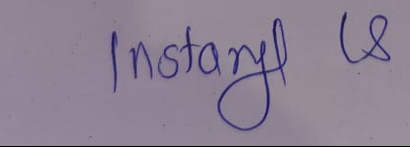

In [11]:
image = Image.open(train_dataset.root_dir + train_df['images'][0]).convert("RGB")
image

In [12]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

Instaryl Ls


In [13]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [15]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    # fp16=True, 
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
)

In [16]:
from datasets import load_metric

cer_metric = load_metric("cer")

C:\Users\Prakhar Jadaun\AppData\Local\Temp\ipykernel_25436\152175726.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


In [17]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}
     

In [18]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)


C:\Users\Prakhar Jadaun\AppData\Roaming\Python\Python311\site-packages\transformers\models\trocr\processing_trocr.py:134: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [19]:
trainer.train()

C:\Users\Prakhar Jadaun\AppData\Roaming\Python\Python311\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  1%|          | 2/231 [03:06<5:42:42, 89.79s/it] 

{'loss': 8.4127, 'learning_rate': 4.956709956709957e-05, 'epoch': 0.03}


  2%|▏         | 4/231 [05:13<4:30:40, 71.55s/it]

{'loss': 5.6003, 'learning_rate': 4.9134199134199135e-05, 'epoch': 0.05}


  3%|▎         | 6/231 [07:07<3:58:18, 63.55s/it]

{'loss': 4.2441, 'learning_rate': 4.87012987012987e-05, 'epoch': 0.08}


  3%|▎         | 8/231 [09:29<4:12:39, 67.98s/it]

{'loss': 3.4999, 'learning_rate': 4.826839826839827e-05, 'epoch': 0.1}


  4%|▍         | 10/231 [11:26<3:51:47, 62.93s/it]

{'loss': 3.9893, 'learning_rate': 4.783549783549784e-05, 'epoch': 0.13}


  5%|▌         | 12/231 [13:13<3:32:22, 58.19s/it]

{'loss': 3.0547, 'learning_rate': 4.740259740259741e-05, 'epoch': 0.16}


  6%|▌         | 14/231 [14:57<3:19:50, 55.26s/it]

{'loss': 3.304, 'learning_rate': 4.696969696969697e-05, 'epoch': 0.18}


  7%|▋         | 16/231 [16:48<3:17:48, 55.20s/it]

{'loss': 3.3393, 'learning_rate': 4.653679653679654e-05, 'epoch': 0.21}


  8%|▊         | 18/231 [18:42<3:19:38, 56.24s/it]

{'loss': 2.5624, 'learning_rate': 4.6103896103896106e-05, 'epoch': 0.23}


  9%|▊         | 20/231 [20:31<3:14:30, 55.31s/it]

{'loss': 2.7971, 'learning_rate': 4.567099567099568e-05, 'epoch': 0.26}


 10%|▉         | 22/231 [22:22<3:12:31, 55.27s/it]

{'loss': 2.2411, 'learning_rate': 4.523809523809524e-05, 'epoch': 0.29}


 10%|█         | 24/231 [24:17<3:14:46, 56.46s/it]

{'loss': 2.4824, 'learning_rate': 4.4805194805194805e-05, 'epoch': 0.31}


 11%|█▏        | 26/231 [26:12<3:15:12, 57.13s/it]

{'loss': 2.7287, 'learning_rate': 4.437229437229438e-05, 'epoch': 0.34}


 12%|█▏        | 28/231 [28:09<3:14:10, 57.39s/it]

{'loss': 2.0522, 'learning_rate': 4.3939393939393944e-05, 'epoch': 0.36}


 13%|█▎        | 30/231 [30:08<3:14:29, 58.06s/it]

{'loss': 2.6235, 'learning_rate': 4.3506493506493503e-05, 'epoch': 0.39}


 14%|█▍        | 32/231 [32:08<3:15:56, 59.08s/it]

{'loss': 2.0291, 'learning_rate': 4.3073593073593077e-05, 'epoch': 0.42}


 15%|█▍        | 34/231 [34:03<3:12:45, 58.71s/it]

{'loss': 2.2561, 'learning_rate': 4.264069264069264e-05, 'epoch': 0.44}


 16%|█▌        | 36/231 [35:56<3:07:40, 57.74s/it]

{'loss': 2.0741, 'learning_rate': 4.220779220779221e-05, 'epoch': 0.47}


 16%|█▋        | 38/231 [37:58<3:10:19, 59.17s/it]

{'loss': 1.5853, 'learning_rate': 4.1774891774891775e-05, 'epoch': 0.49}


 17%|█▋        | 40/231 [40:01<3:11:21, 60.11s/it]

{'loss': 1.9205, 'learning_rate': 4.134199134199134e-05, 'epoch': 0.52}


 18%|█▊        | 42/231 [42:04<3:12:18, 61.05s/it]

{'loss': 2.2054, 'learning_rate': 4.0909090909090915e-05, 'epoch': 0.55}


 19%|█▉        | 44/231 [44:06<3:11:31, 61.45s/it]

{'loss': 1.8044, 'learning_rate': 4.047619047619048e-05, 'epoch': 0.57}


 20%|█▉        | 46/231 [46:04<3:04:19, 59.78s/it]

{'loss': 2.5653, 'learning_rate': 4.004329004329004e-05, 'epoch': 0.6}


 21%|██        | 48/231 [47:59<2:57:39, 58.25s/it]

{'loss': 1.7587, 'learning_rate': 3.9610389610389614e-05, 'epoch': 0.62}


 22%|██▏       | 50/231 [49:58<2:58:27, 59.16s/it]

{'loss': 1.6929, 'learning_rate': 3.917748917748918e-05, 'epoch': 0.65}


 23%|██▎       | 52/231 [51:56<2:56:51, 59.28s/it]

{'loss': 2.0747, 'learning_rate': 3.8744588744588746e-05, 'epoch': 0.68}


 23%|██▎       | 54/231 [54:06<3:03:52, 62.33s/it]

{'loss': 1.6688, 'learning_rate': 3.831168831168831e-05, 'epoch': 0.7}


 24%|██▍       | 56/231 [56:46<3:30:51, 72.30s/it]

{'loss': 1.3886, 'learning_rate': 3.787878787878788e-05, 'epoch': 0.73}


 25%|██▌       | 58/231 [59:18<3:32:57, 73.86s/it]

{'loss': 1.1621, 'learning_rate': 3.7445887445887445e-05, 'epoch': 0.75}


 26%|██▌       | 60/231 [1:01:40<3:25:36, 72.14s/it]

{'loss': 0.9729, 'learning_rate': 3.701298701298702e-05, 'epoch': 0.78}


 27%|██▋       | 62/231 [1:03:56<3:17:02, 69.96s/it]

{'loss': 0.965, 'learning_rate': 3.6580086580086584e-05, 'epoch': 0.81}


 28%|██▊       | 64/231 [1:06:12<3:11:23, 68.77s/it]

{'loss': 1.6249, 'learning_rate': 3.6147186147186144e-05, 'epoch': 0.83}


 29%|██▊       | 66/231 [1:08:25<3:05:49, 67.57s/it]

{'loss': 1.2646, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.86}


 29%|██▉       | 68/231 [1:10:46<3:08:52, 69.53s/it]

{'loss': 1.2593, 'learning_rate': 3.528138528138528e-05, 'epoch': 0.88}


 30%|███       | 70/231 [1:13:00<3:03:17, 68.31s/it]

{'loss': 1.2594, 'learning_rate': 3.484848484848485e-05, 'epoch': 0.91}


 31%|███       | 72/231 [1:15:15<3:00:11, 68.00s/it]

{'loss': 1.448, 'learning_rate': 3.4415584415584416e-05, 'epoch': 0.94}


 32%|███▏      | 74/231 [1:17:28<2:55:45, 67.17s/it]

{'loss': 1.17, 'learning_rate': 3.398268398268398e-05, 'epoch': 0.96}


 33%|███▎      | 76/231 [1:19:42<2:53:21, 67.11s/it]

{'loss': 0.914, 'learning_rate': 3.3549783549783555e-05, 'epoch': 0.99}


 34%|███▍      | 78/231 [1:21:27<2:36:00, 61.18s/it]

{'loss': 0.8288, 'learning_rate': 3.311688311688312e-05, 'epoch': 1.01}


 35%|███▍      | 80/231 [1:23:45<2:43:32, 64.99s/it]

{'loss': 0.7855, 'learning_rate': 3.268398268398268e-05, 'epoch': 1.04}


 35%|███▌      | 82/231 [1:26:03<2:46:10, 66.92s/it]

{'loss': 0.8135, 'learning_rate': 3.2251082251082254e-05, 'epoch': 1.06}


 36%|███▋      | 84/231 [1:28:18<2:44:35, 67.18s/it]

{'loss': 0.6169, 'learning_rate': 3.181818181818182e-05, 'epoch': 1.09}


 37%|███▋      | 86/231 [1:30:35<2:44:06, 67.91s/it]

{'loss': 0.6534, 'learning_rate': 3.1385281385281387e-05, 'epoch': 1.12}


 38%|███▊      | 88/231 [1:32:52<2:42:24, 68.14s/it]

{'loss': 0.6573, 'learning_rate': 3.095238095238095e-05, 'epoch': 1.14}


 39%|███▉      | 90/231 [1:35:09<2:40:41, 68.38s/it]

{'loss': 0.621, 'learning_rate': 3.051948051948052e-05, 'epoch': 1.17}


 40%|███▉      | 92/231 [1:37:33<2:43:17, 70.48s/it]

{'loss': 0.4939, 'learning_rate': 3.0086580086580092e-05, 'epoch': 1.19}


 41%|████      | 94/231 [1:39:54<2:41:03, 70.54s/it]

{'loss': 0.7576, 'learning_rate': 2.9653679653679655e-05, 'epoch': 1.22}


 42%|████▏     | 96/231 [1:42:13<2:37:34, 70.03s/it]

{'loss': 0.5393, 'learning_rate': 2.922077922077922e-05, 'epoch': 1.25}


 42%|████▏     | 98/231 [1:44:34<2:35:24, 70.11s/it]

{'loss': 0.6676, 'learning_rate': 2.878787878787879e-05, 'epoch': 1.27}


 43%|████▎     | 100/231 [1:46:53<2:32:31, 69.86s/it]

{'loss': 0.7977, 'learning_rate': 2.8354978354978357e-05, 'epoch': 1.3}


 44%|████▍     | 102/231 [1:48:59<2:21:28, 65.80s/it]

{'loss': 0.5042, 'learning_rate': 2.792207792207792e-05, 'epoch': 1.32}


 45%|████▌     | 104/231 [1:51:18<2:23:30, 67.80s/it]

{'loss': 0.4832, 'learning_rate': 2.7489177489177493e-05, 'epoch': 1.35}


 46%|████▌     | 106/231 [1:53:29<2:19:36, 67.02s/it]

{'loss': 0.8545, 'learning_rate': 2.7056277056277056e-05, 'epoch': 1.38}


 47%|████▋     | 108/231 [1:55:36<2:13:12, 64.98s/it]

{'loss': 0.4892, 'learning_rate': 2.6623376623376623e-05, 'epoch': 1.4}


 48%|████▊     | 110/231 [1:57:37<2:06:24, 62.68s/it]

{'loss': 0.7047, 'learning_rate': 2.6190476190476192e-05, 'epoch': 1.43}


 48%|████▊     | 112/231 [1:59:36<2:02:02, 61.53s/it]

{'loss': 0.3917, 'learning_rate': 2.575757575757576e-05, 'epoch': 1.45}


 49%|████▉     | 114/231 [2:01:39<2:00:58, 62.04s/it]

{'loss': 0.6769, 'learning_rate': 2.5324675324675325e-05, 'epoch': 1.48}


 50%|█████     | 116/231 [2:03:43<1:59:27, 62.32s/it]

{'loss': 0.5002, 'learning_rate': 2.4891774891774894e-05, 'epoch': 1.51}


 51%|█████     | 118/231 [2:05:33<1:50:37, 58.74s/it]

{'loss': 0.4279, 'learning_rate': 2.4458874458874457e-05, 'epoch': 1.53}


 52%|█████▏    | 120/231 [2:07:33<1:49:16, 59.07s/it]

{'loss': 0.5237, 'learning_rate': 2.4025974025974027e-05, 'epoch': 1.56}


 53%|█████▎    | 122/231 [2:09:34<1:48:07, 59.52s/it]

{'loss': 0.4746, 'learning_rate': 2.3593073593073593e-05, 'epoch': 1.58}


 54%|█████▎    | 124/231 [2:11:37<1:46:36, 59.78s/it]

{'loss': 0.5802, 'learning_rate': 2.3160173160173163e-05, 'epoch': 1.61}


 55%|█████▍    | 126/231 [2:13:41<1:46:02, 60.60s/it]

{'loss': 0.6385, 'learning_rate': 2.272727272727273e-05, 'epoch': 1.64}


 55%|█████▌    | 128/231 [2:15:53<1:48:27, 63.18s/it]

{'loss': 0.6514, 'learning_rate': 2.2294372294372296e-05, 'epoch': 1.66}


 56%|█████▋    | 130/231 [2:18:01<1:47:28, 63.84s/it]

{'loss': 0.7177, 'learning_rate': 2.1861471861471862e-05, 'epoch': 1.69}


 57%|█████▋    | 132/231 [2:19:56<1:39:50, 60.51s/it]

{'loss': 0.8269, 'learning_rate': 2.1428571428571428e-05, 'epoch': 1.71}


 58%|█████▊    | 134/231 [2:21:55<1:35:55, 59.34s/it]

{'loss': 0.4536, 'learning_rate': 2.0995670995670998e-05, 'epoch': 1.74}


 59%|█████▉    | 136/231 [2:23:59<1:36:08, 60.72s/it]

{'loss': 0.5929, 'learning_rate': 2.0562770562770564e-05, 'epoch': 1.77}


 60%|█████▉    | 138/231 [2:25:52<1:30:57, 58.68s/it]

{'loss': 0.3787, 'learning_rate': 2.012987012987013e-05, 'epoch': 1.79}


 61%|██████    | 140/231 [2:27:53<1:29:49, 59.22s/it]

{'loss': 0.3762, 'learning_rate': 1.9696969696969697e-05, 'epoch': 1.82}


 61%|██████▏   | 142/231 [2:29:51<1:27:31, 59.00s/it]

{'loss': 0.3573, 'learning_rate': 1.9264069264069266e-05, 'epoch': 1.84}


 62%|██████▏   | 144/231 [2:31:53<1:27:23, 60.28s/it]

{'loss': 0.4678, 'learning_rate': 1.8831168831168833e-05, 'epoch': 1.87}


 63%|██████▎   | 146/231 [2:33:54<1:26:20, 60.95s/it]

{'loss': 0.4105, 'learning_rate': 1.83982683982684e-05, 'epoch': 1.9}


 64%|██████▍   | 148/231 [2:35:50<1:22:32, 59.67s/it]

{'loss': 0.3397, 'learning_rate': 1.7965367965367965e-05, 'epoch': 1.92}


 65%|██████▍   | 150/231 [2:37:48<1:20:01, 59.28s/it]

{'loss': 0.501, 'learning_rate': 1.7532467532467535e-05, 'epoch': 1.95}


 66%|██████▌   | 152/231 [2:39:47<1:18:03, 59.29s/it]

{'loss': 0.2906, 'learning_rate': 1.70995670995671e-05, 'epoch': 1.97}


 67%|██████▋   | 154/231 [2:41:15<1:04:49, 50.51s/it]

{'loss': 0.4378, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}


 68%|██████▊   | 156/231 [2:43:21<1:11:32, 57.23s/it]

{'loss': 0.4538, 'learning_rate': 1.6233766233766234e-05, 'epoch': 2.03}


 68%|██████▊   | 158/231 [2:45:28<1:14:13, 61.00s/it]

{'loss': 0.433, 'learning_rate': 1.5800865800865803e-05, 'epoch': 2.05}


 69%|██████▉   | 160/231 [2:47:27<1:11:18, 60.26s/it]

{'loss': 0.2194, 'learning_rate': 1.5367965367965366e-05, 'epoch': 2.08}


 70%|███████   | 162/231 [2:49:23<1:07:31, 58.72s/it]

{'loss': 0.3805, 'learning_rate': 1.4935064935064936e-05, 'epoch': 2.1}


 71%|███████   | 164/231 [2:51:25<1:06:24, 59.48s/it]

{'loss': 0.2982, 'learning_rate': 1.4502164502164502e-05, 'epoch': 2.13}


 72%|███████▏  | 166/231 [2:53:32<1:06:57, 61.81s/it]

{'loss': 0.3058, 'learning_rate': 1.406926406926407e-05, 'epoch': 2.16}


 73%|███████▎  | 168/231 [2:55:34<1:05:14, 62.14s/it]

{'loss': 0.3141, 'learning_rate': 1.3636363636363637e-05, 'epoch': 2.18}


 74%|███████▎  | 170/231 [2:57:38<1:02:10, 61.16s/it]

{'loss': 0.4227, 'learning_rate': 1.3203463203463205e-05, 'epoch': 2.21}


 74%|███████▍  | 172/231 [2:59:26<56:39, 57.62s/it]  

{'loss': 0.242, 'learning_rate': 1.2770562770562773e-05, 'epoch': 2.23}


 75%|███████▌  | 174/231 [3:01:27<56:05, 59.05s/it]

{'loss': 0.2744, 'learning_rate': 1.2337662337662339e-05, 'epoch': 2.26}


 76%|███████▌  | 176/231 [3:03:23<53:51, 58.75s/it]

{'loss': 0.4196, 'learning_rate': 1.1904761904761905e-05, 'epoch': 2.29}


 77%|███████▋  | 178/231 [3:05:22<52:10, 59.07s/it]

{'loss': 0.3155, 'learning_rate': 1.1471861471861473e-05, 'epoch': 2.31}


 78%|███████▊  | 180/231 [3:07:21<50:35, 59.52s/it]

{'loss': 0.3664, 'learning_rate': 1.103896103896104e-05, 'epoch': 2.34}


 79%|███████▉  | 182/231 [3:09:18<48:23, 59.25s/it]

{'loss': 0.385, 'learning_rate': 1.0606060606060607e-05, 'epoch': 2.36}


 80%|███████▉  | 184/231 [3:11:21<46:56, 59.94s/it]

{'loss': 0.2253, 'learning_rate': 1.0173160173160174e-05, 'epoch': 2.39}


 81%|████████  | 186/231 [3:13:18<44:41, 59.59s/it]

{'loss': 0.2889, 'learning_rate': 9.740259740259742e-06, 'epoch': 2.42}


 81%|████████▏ | 188/231 [3:15:10<41:29, 57.91s/it]

{'loss': 0.2489, 'learning_rate': 9.307359307359308e-06, 'epoch': 2.44}


 82%|████████▏ | 190/231 [3:17:28<42:47, 62.61s/it]

{'loss': 0.2672, 'learning_rate': 8.874458874458876e-06, 'epoch': 2.47}


 83%|████████▎ | 192/231 [3:19:17<38:09, 58.70s/it]

{'loss': 0.4576, 'learning_rate': 8.441558441558442e-06, 'epoch': 2.49}


 84%|████████▍ | 194/231 [3:21:11<35:42, 57.89s/it]

{'loss': 0.3498, 'learning_rate': 8.008658008658008e-06, 'epoch': 2.52}


 85%|████████▍ | 196/231 [3:23:07<33:39, 57.69s/it]

{'loss': 0.2699, 'learning_rate': 7.5757575757575764e-06, 'epoch': 2.55}


 86%|████████▌ | 198/231 [3:25:13<32:49, 59.69s/it]

{'loss': 0.3026, 'learning_rate': 7.142857142857143e-06, 'epoch': 2.57}


 87%|████████▋ | 200/231 [3:27:15<31:19, 60.62s/it]

{'loss': 0.2838, 'learning_rate': 6.709956709956711e-06, 'epoch': 2.6}


C:\Users\Prakhar Jadaun\AppData\Roaming\Python\Python311\site-packages\transformers\generation\utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
                                                   
 87%|████████▋ | 200/231 [4:15:43<31:19, 60.62s/it]

{'eval_loss': 0.267742782831192, 'eval_cer': 0.010610079575596816, 'eval_runtime': 2908.3963, 'eval_samples_per_second': 0.053, 'eval_steps_per_second': 0.007, 'epoch': 2.6}


 87%|████████▋ | 202/231 [4:17:57<5:26:11, 674.89s/it]

{'loss': 0.2844, 'learning_rate': 6.277056277056277e-06, 'epoch': 2.62}


 88%|████████▊ | 204/231 [4:19:54<2:42:06, 360.23s/it]

{'loss': 0.3805, 'learning_rate': 5.844155844155844e-06, 'epoch': 2.65}


 89%|████████▉ | 206/231 [4:21:54<1:26:03, 206.53s/it]

{'loss': 0.3213, 'learning_rate': 5.411255411255411e-06, 'epoch': 2.68}


 90%|█████████ | 208/231 [4:23:57<50:39, 132.13s/it]  

{'loss': 0.2308, 'learning_rate': 4.978354978354978e-06, 'epoch': 2.7}


 91%|█████████ | 210/231 [4:25:57<33:25, 95.52s/it] 

{'loss': 0.3064, 'learning_rate': 4.5454545454545455e-06, 'epoch': 2.73}


 92%|█████████▏| 212/231 [4:27:57<24:37, 77.77s/it]

{'loss': 0.2478, 'learning_rate': 4.112554112554113e-06, 'epoch': 2.75}


 93%|█████████▎| 214/231 [4:29:50<18:54, 66.72s/it]

{'loss': 0.2396, 'learning_rate': 3.67965367965368e-06, 'epoch': 2.78}


 94%|█████████▎| 216/231 [4:31:53<16:11, 64.75s/it]

{'loss': 0.2549, 'learning_rate': 3.2467532467532465e-06, 'epoch': 2.81}


 94%|█████████▍| 218/231 [4:33:55<13:40, 63.14s/it]

{'loss': 0.2489, 'learning_rate': 2.813852813852814e-06, 'epoch': 2.83}


 95%|█████████▌| 220/231 [4:35:57<11:28, 62.60s/it]

{'loss': 0.2516, 'learning_rate': 2.3809523809523808e-06, 'epoch': 2.86}


 96%|█████████▌| 222/231 [4:37:52<08:56, 59.66s/it]

{'loss': 0.2609, 'learning_rate': 1.948051948051948e-06, 'epoch': 2.88}


 97%|█████████▋| 224/231 [4:39:46<06:45, 57.95s/it]

{'loss': 0.2225, 'learning_rate': 1.5151515151515152e-06, 'epoch': 2.91}


 98%|█████████▊| 226/231 [4:41:46<04:52, 58.44s/it]

{'loss': 0.3319, 'learning_rate': 1.0822510822510822e-06, 'epoch': 2.94}


 99%|█████████▊| 228/231 [4:43:48<02:57, 59.30s/it]

{'loss': 0.2426, 'learning_rate': 6.493506493506494e-07, 'epoch': 2.96}


100%|█████████▉| 230/231 [4:45:51<01:00, 60.02s/it]

{'loss': 0.2489, 'learning_rate': 2.1645021645021646e-07, 'epoch': 2.99}


100%|██████████| 231/231 [4:46:25<00:00, 74.39s/it]


{'train_runtime': 17185.2005, 'train_samples_per_second': 0.107, 'train_steps_per_second': 0.013, 'train_loss': 1.07376468620259, 'epoch': 3.0}


TrainOutput(global_step=231, training_loss=1.07376468620259, metrics={'train_runtime': 17185.2005, 'train_samples_per_second': 0.107, 'train_steps_per_second': 0.013, 'train_loss': 1.07376468620259, 'epoch': 3.0})

In [20]:
# trainer.save_model("model")

In [51]:
df=pd.DataFrame(trainer.state.log_history)
df

,loss,learning_rate,epoch,step,eval_loss,eval_cer,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,8.4127,4.956710e-05,0.03,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.6003,4.913420e-05,0.05,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.2441,4.870130e-05,0.08,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.4999,4.826840e-05,0.10,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.9893,4.783550e-05,0.13,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,0.2225,1.515152e-06,2.91,224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113,0.3319,1.082251e-06,2.94,226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,0.2426,6.493506e-07,2.96,228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,0.2489,2.164502e-07,2.99,230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
df[df['loss'].isna()]

,loss,learning_rate,epoch,step,eval_loss,eval_cer,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
100,NaN,NaN,2.6,200,0.267743,0.01061,2908.3963,0.053,0.007,NaN,NaN,NaN,NaN,NaN
116,NaN,NaN,3.0,231,NaN,NaN,NaN,NaN,NaN,17185.2005,0.107,0.013,1.624668e+18,1.073765


In [53]:
df.drop([df.index[100],df.index[116]],inplace=True)

In [54]:
df[df['loss'].isna()]

,loss,learning_rate,epoch,step,eval_loss,eval_cer,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss


In [55]:
x = df['loss'].to_list()
y = df['epoch'].to_list()

In [56]:
import matplotlib.pyplot as plt

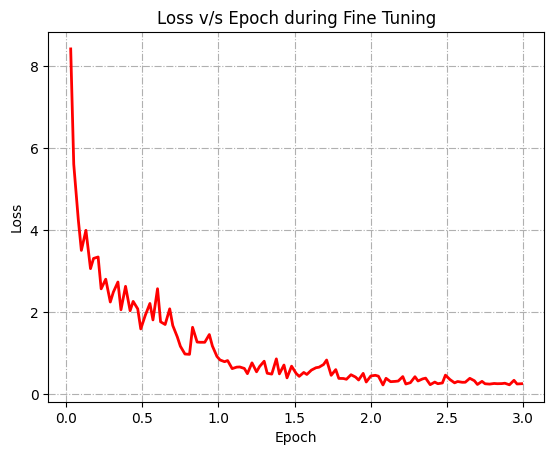

In [57]:
plt.plot(y,x,color='red',linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss v/s Epoch during Fine Tuning")
plt.grid(linestyle='dashdot')
plt.show()

In [59]:
df.columns

Index(['loss', 'learning_rate', 'epoch', 'step', 'eval_loss', 'eval_cer',
       'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second',
       'train_runtime', 'train_samples_per_second', 'train_steps_per_second',
       'total_flos', 'train_loss'],
      dtype='object')